In [74]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageDraw
import json
import cv2

In [183]:
img_path = '/storage/scratch/e17-4yp-autonomous-driving/g04/TCP/data/results_TCP/routes_lav_valid_06_19_16_24_50/'
num = '0160'

In [184]:
img = Image.open('{path}rgb/{num}.png'.format(path=img_path, num=num))
# img = Image.open('/storage/scratch/e17-4yp-autonomous-driving/g04/TCP/data/results_TCP/routes_lav_valid_06_19_17_07_02/bev/1709.png')

In [185]:
j = open('{path}meta/{num}.json'.format(path=img_path, num=num))
data = json.load(j)
data

{'speed': -0.00014356881729327142,
 'steer': 0.05285595202509603,
 'throttle': 0.75,
 'brake': 0.0,
 'wp_4': [0.22320181131362915, 4.009021282196045],
 'wp_3': [0.1316862404346466, 2.024167060852051],
 'wp_2': [0.02612614631652832, 0.5911548137664795],
 'wp_1': [-0.000766851007938385, 0.08112680912017822],
 'aim': [0.1316862404346466, 2.024167060852051],
 'target': [1.3568278551101685, 42.852081298828125],
 'desired_speed': 2.62306288878123,
 'angle': 0.04135828541670757,
 'angle_last': 0.029331840108130676,
 'angle_target': 0.02015062393480876,
 'angle_final': 0.02015062393480876,
 'delta': 0.25,
 'agent': 'ctrl',
 'steer_ctrl': 0.2098078727722168,
 'steer_traj': 0.05285595202509603,
 'throttle_ctrl': 0.0,
 'throttle_traj': 0.75,
 'brake_ctrl': 1.0,
 'brake_traj': 0.0,
 'status': 1}

In [186]:
size = img.size
size = list(size)
size

[900, 256]

In [187]:
wps = [data['wp_1'], data['wp_2'], data['wp_3'], data['wp_4']]
waypoints_x = [(i[0]*size[0])+size[0]/2 for i in wps]
waypoints_y = [size[1] - (i[1]*size[1]) for i in wps]

In [188]:
x_c, y_c, z_c = -1.5, 0.0, 2.0  # camera centers
C_u, C_v = 900 / 2, 256 / 2
F_x = 900 /(2 * np.tan(100 * np.pi / 360))
F_y = 256 /(2 * np.tan(100 * np.pi / 360))

# calculating extrinsic matrix
E = np.zeros((3, 4))

# Using E = [R | t]
# R is Yaw * Pitch * Roll (all are 0)
E[:3, :3] = np.eye(3)  # R = Identity
E[:, 3] = -np.array([x_c, y_c, z_c])  # t = - R C

# Intrinsic camera matrix
K = np.array([
    [F_x, 0, C_u],
    [0, F_y, C_v],
    [0, 0, 1]
])

E = [[0,-1,0,0],[0,0,-1,2],[1,0,0,1.5]]

# waypoint predictions
out = {
    'wp1': [data['wp_1'][1], data['wp_1'][0]*-1],
    'wp2': [data['wp_2'][1], data['wp_2'][0]*-1],
    'wp3': [data['wp_3'][1], data['wp_3'][0]*-1],
    'wp4': [data['wp_4'][1], data['wp_4'][0]*-1]
}
# stacking waypoint predictions
wp = np.zeros((4, 4))
wp[0:2, 0] = np.array(out['wp1'])
wp[0:2, 1] = np.array(out['wp2'])
wp[0:2, 2] = np.array(out['wp3'])
wp[0:2, 3] = np.array(out['wp4'])
# z coordinate is set to zero


# setting homogenous coordinate to 1
wp[-1, :] = np.ones(4)
print(E)
img_coords = K @ E @ wp

[[0, -1, 0, 0], [0, 0, -1, 2], [1, 0, 0, 1.5]]


In [189]:
img_coords = img_coords[:2]/img_coords[2]
img_coords

array([[449.81686543, 454.71753589, 464.10944579, 465.29851612],
       [263.85849303, 230.72290897, 188.95326977, 166.99231725]])

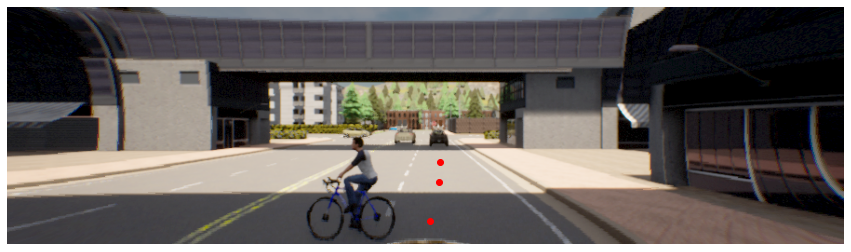

In [190]:
image = img
image_width = size[0]
image_height = size[1]

# Plotting the image
plt.figure(figsize=(15, 15))
plt.imshow(image)
plt.axis('off')  # Turn off the axis

# Plotting the image coordinates
plt.scatter(img_coords[0, :], img_coords[1, :], color='red', marker='o')

# Adjusting the aspect ratio
plt.gca().set_aspect('equal', adjustable='box')

# Setting the limits of the plot
plt.xlim(0, image_width)
plt.ylim(image_height, 0)

# Displaying the plot
plt.show()
